# Brendan Quinn 21xxxxxx, Milan Kovacs 21308128

Code runs to execution

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix
import os.path
from keras import utils
import keras
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import GridSearchCV

# Code taken from the book "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" by Aurélien Géron
print("Imported all the libraries")

Imported all the libraries


In [2]:
# Load Data
path = f"C:\\Users\\{os.getlogin()}\\.cache\\kagglehub\\datasets\\misrakahmed\\vegetable-image-dataset\\versions\\1\\Vegetable Images"

# Check if dataset is downloaded
if not os.path.exists(path):
    kagglehub.dataset_download("misrakahmed/vegetable-image-dataset")
    path = kagglehub.dataset_download("misrakahmed/vegetable-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\kmila\.cache\kagglehub\datasets\misrakahmed\vegetable-image-dataset\versions\1\Vegetable Images


Loading the images we ran into the issue of not enough memory. Just to load the 14,994 training required more than 8GB of memory. So looking further we found that ImageDataGenerator can load images as they go, however it is deprecated. So we will use tf.data following this tutorial: https://www.scaler.com/topics/keras/image-data-pipelines-in-keras/

We then ran into an error when trying to convert the images int the numpy array:  
ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (15000,) + inhomogeneous part. 

This suggested that the images were inconsistent sizes, so we omit images that are not (224, 224)

In [4]:
# Get the list of images:
FOLDERS = ["train", "test", "validation"]
dataset_map = {folder_name: [] for folder_name in FOLDERS}

for folder in FOLDERS:
    for root, dirs, files in os.walk(f"{path}\\{folder}"):
        vegetable_type = os.path.basename(root)
        
        for file in files:
            file_path = os.path.join(root, file)
            image = keras.utils.load_img(file_path)
            if image.size == (224, 224):
                dataset_map[folder].append((file_path, vegetable_type))

for i in dataset_map:
    print(f"Path of {i} has {len(dataset_map[i])} images")   


Path of train has 14994 images
Path of test has 2999 images
Path of validation has 2998 images


In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    f"{path}\\train",
    labels="inferred",
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    f"{path}\\test",
    labels="inferred",
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    f"{path}\\validation",
    labels="inferred",
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42
)

normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


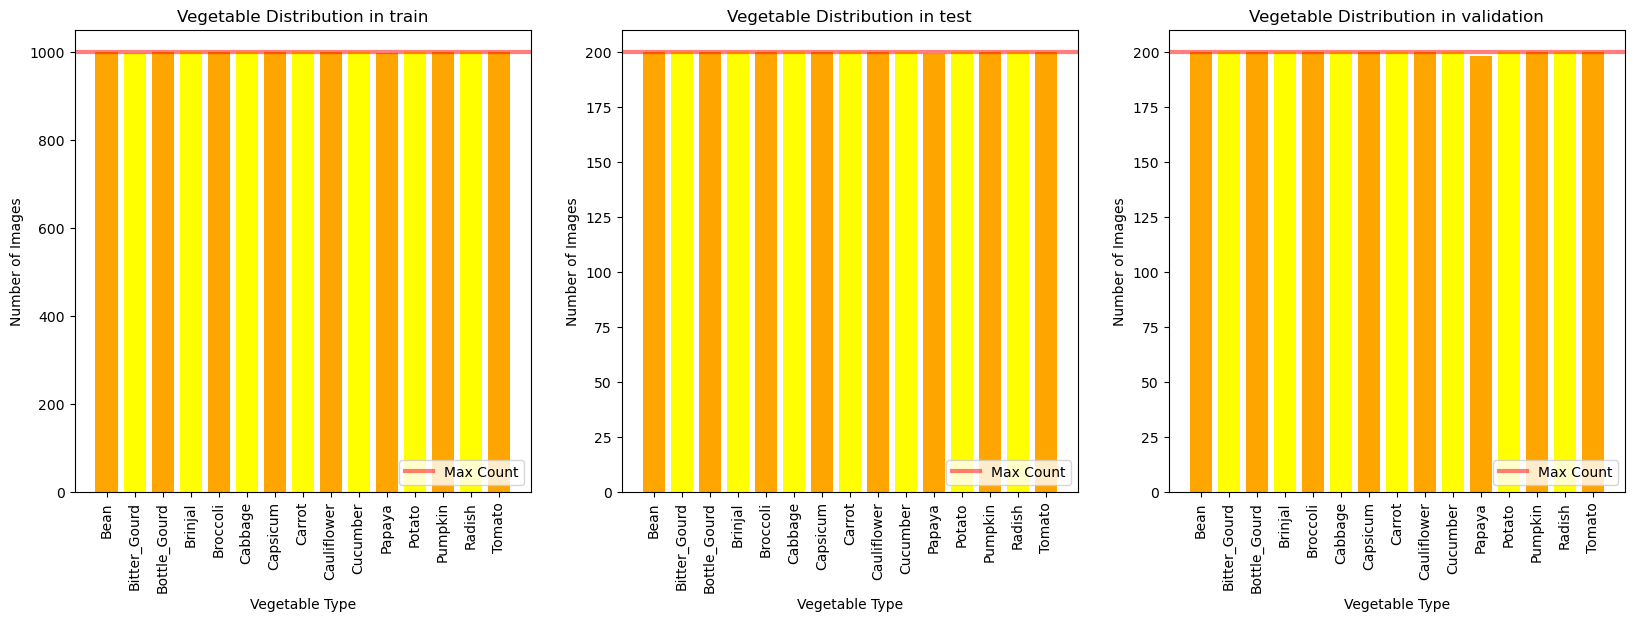

In [36]:
# Bar chart
fig, axis = plt.subplots(1,3)
fig.set_figheight(6)
fig.set_figwidth(20)

vegetable_types = set()

for index, set_type in enumerate(dataset_map):
    vegetable_types.add(set_type)
    plot = axis[index]
    vegetables_data_set = [x[1] for x in dataset_map[set_type]]
    
    vegetables_counts = Counter(vegetables_data_set)
    plot.title.set_text(set_type)
    plot.bar(vegetables_counts.keys(), vegetables_counts.values(), color=['orange', 'yellow'])
    x_axis = plot.get_xticklabels()
    plot.tick_params(axis='x',  labelsize=10, labelrotation=90)
    plot.set(xlabel = 'Vegetable Type', ylabel='Number of Images', title=f"Vegetable Distribution in {set_type}")
    
    max_count = max(vegetables_counts.values())
    plot.axhline(y=max_count, color='red', linestyle='-', label='Max Count', linewidth=3, alpha=0.5)

    plot.legend(loc='lower right')
plt.show()

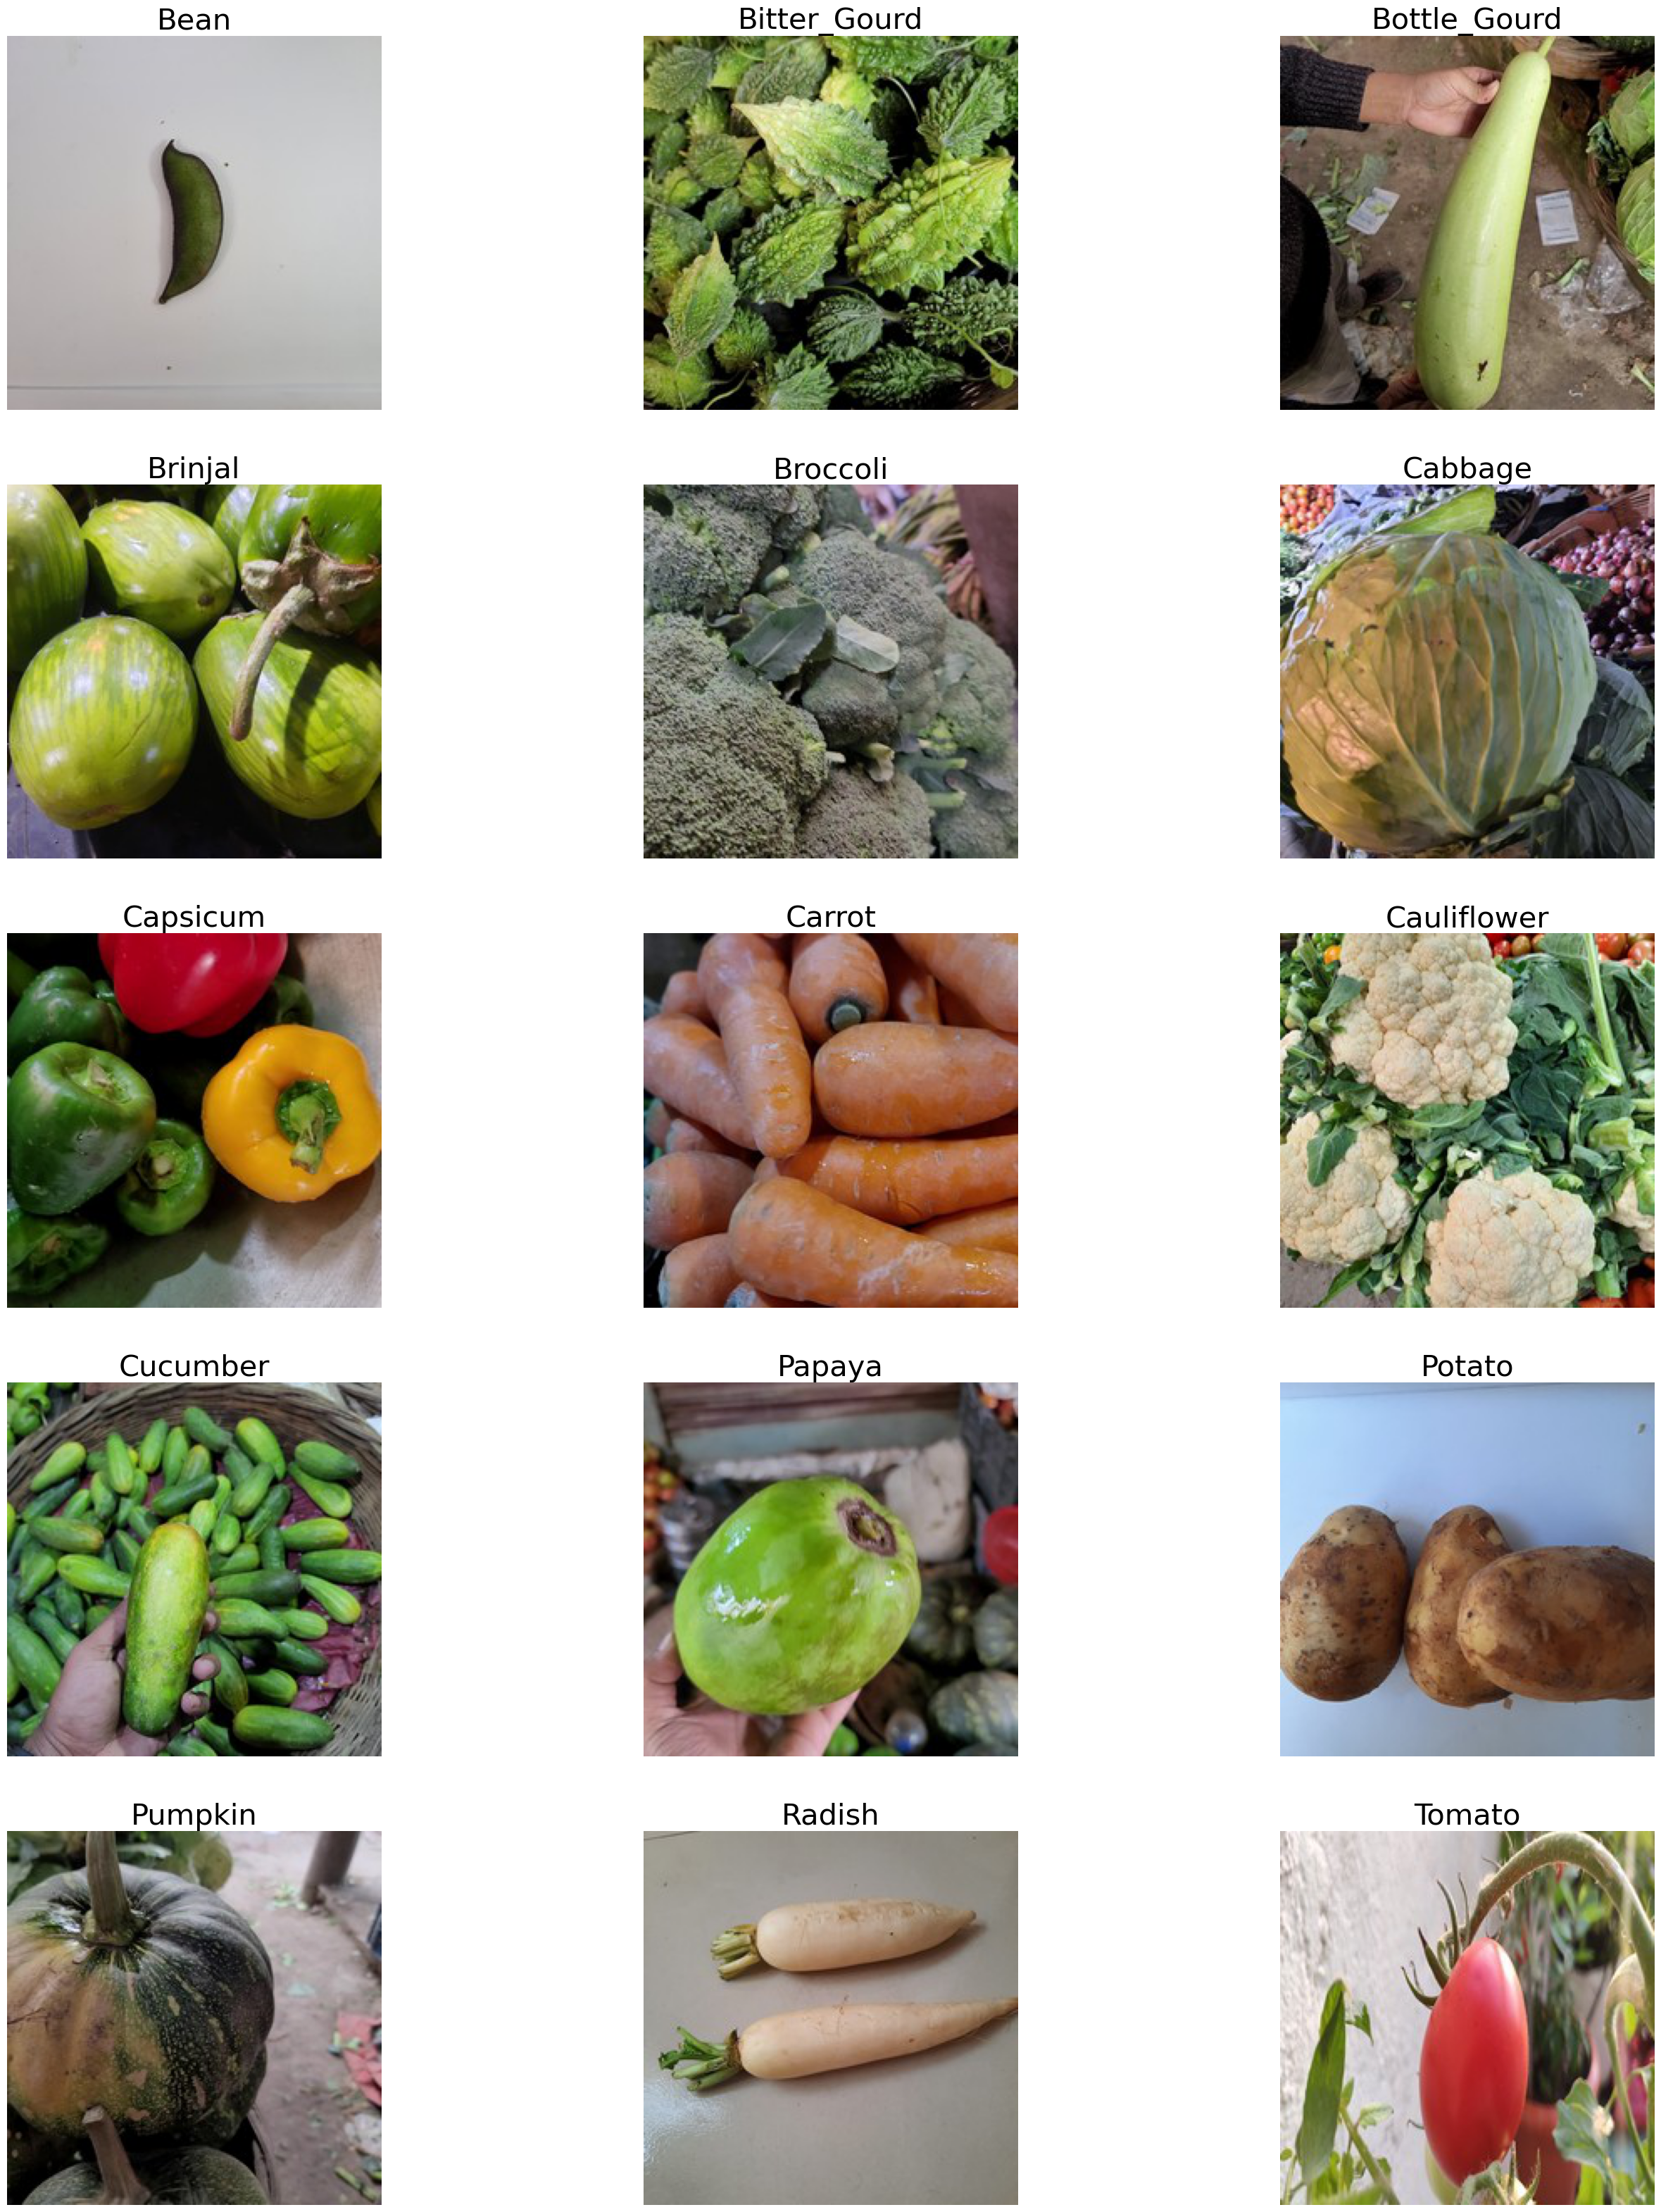

In [37]:
# Sample images
np.random.seed(42)

training_path, training_label = zip(*dataset_map["train"])

sample_images = []

fig, axis = plt.subplots(5, 3)
fig.set_figheight(40)
fig.set_figwidth(35)
plt.subplots_adjust(hspace=0.2, wspace=0.0)

for i in range(1, 15 * 1000 + 1, 1000):
    sample_images.append(
        (training_path[i - 1], training_label[i - 1])
    )

for index, (img_path, label) in enumerate(sample_images):
    plot = axis[index // 3, index % 3]
    plot.imshow(keras.utils.load_img(img_path))
    plot.set_title(label, size=30)
    plot.axis("off")

plt.show()

Loading the images we ran into the issue of not enough memory. Just to load the 14,994 training required more than 8GB of memory. So looking further we found that ImageDataGenerator can load images as they go, however it is deprecated. So we will use tf.data following this tutorial: https://www.scaler.com/topics/keras/image-data-pipelines-in-keras/

In [38]:
# Cross-validation



In [8]:
# Make sure GPU is set as the default device
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is being used for training.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available, using CPU instead.")


No GPU available, using CPU instead.


# Kernel Initialization 
We are using Relu so we can use He_initialization 

In [4]:
# Model Configuration
from tensorflow import keras
from scikeras.wrappers import KerasClassifier

# Chapter 2: Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow by Aurélien Géron
# Yolo model architecture: https://www.datacamp.com/blog/yolo-object-detection-explained
# 24 Convolutional layers
# 2 Fully connected layers
# 4 Max pooling layers

def create_yolo_model(learning_rate=0.001, 
                 epochs=10,
                 batch_size=64,
                 optimizer='adam',
                 activation='relu',
                 dropout_rate=0.5,
              loss ='mean_squared_error' 
                 ) -> keras.models.Sequential:
    model = keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(224, 224, 3)))
    # Resize the input image into 448x448
    # Conv. Layer 7x7x64-s-2 -> Max Pooling 2x2-s-2 -> Conv. Layer 3x3x192 -> Max Pooling 2x2-s-2
    model.add(tf.keras.layers.Conv2D(64, kernel_initializer="he_normal", kernel_size=7, strides=2, padding='same', activation=activation))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
    print(model.output_shape)

    model.add(tf.keras.layers.Conv2D(192, kernel_initializer="he_normal", kernel_size=3, padding='same', activation=activation))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
    print(model.output_shape)

    # Conv. Layers [1x1x128, 3x3x256, 1x1x256, 3x3x512] -> Max Pooling 2x2-s-2
    model.add(tf.keras.layers.Conv2D(128, kernel_initializer="he_normal", kernel_size=1, activation=activation))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(256, kernel_initializer="he_normal", kernel_size=3, padding='same', activation=activation))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(256, kernel_initializer="he_normal", kernel_size=1, activation=activation))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(512, kernel_initializer="he_normal", kernel_size=3, padding='same', activation=activation))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
    print(model.output_shape)

    # Conv. Layers [1x1x256, 3x3x512]x4 [1x1x512, 3x3x1024] -> Max Pooling 2x2-s-2
    model.add(tf.keras.layers.Conv2D(256, kernel_initializer="he_normal", kernel_size=1, activation=activation))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(512, kernel_initializer="he_normal", kernel_size=3, padding='same',activation=activation))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(256, kernel_initializer="he_normal", kernel_size=1, activation=activation))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(512, kernel_initializer="he_normal", kernel_size=3, padding='same',activation=activation))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(256, kernel_initializer="he_normal", kernel_size=1, activation=activation))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(512, kernel_initializer="he_normal", kernel_size=3, padding='same',activation=activation))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(256, kernel_initializer="he_normal", kernel_size=1, activation=activation))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(512, kernel_initializer="he_normal", kernel_size=3, padding='same',activation=activation))
    model.add(tf.keras.layers.BatchNormalization())

    print(model.output_shape)

    model.add(tf.keras.layers.Conv2D(512, kernel_initializer="he_normal", kernel_size=1, activation=activation))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(1024, kernel_initializer="he_normal", kernel_size=3, padding='same',activation=activation))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
    print(model.output_shape)

    # Conv. Layers [1x1x512, 3x3x1024]x2 [3x3x1024, 3x3x1024]x2 -> Conv. Layer 3x3x1024-s-2
    model.add(tf.keras.layers.Conv2D(512, kernel_initializer="he_normal", kernel_size=1, activation=activation))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(1024, kernel_initializer="he_normal", kernel_size=3, padding='same',activation=activation))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(512, kernel_initializer="he_normal", kernel_size=1, activation=activation))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(1024, kernel_initializer="he_normal", kernel_size=3, padding='same',activation=activation))
    model.add(tf.keras.layers.BatchNormalization())

    print(model.output_shape)

    model.add(tf.keras.layers.Conv2D(1024, kernel_initializer="he_normal", kernel_size=3, padding='same',activation=activation))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(1024, kernel_initializer="he_normal", kernel_size=3, padding='same',activation=activation))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(1024, kernel_initializer="he_normal", kernel_size=3, padding='same',activation=activation))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(1024, kernel_initializer="he_normal", kernel_size=3, padding='same',activation=activation))
    model.add(tf.keras.layers.BatchNormalization())

    print(model.output_shape)

    model.add(tf.keras.layers.Conv2D(1024, kernel_initializer="he_normal", kernel_size=3, strides=2, activation=activation))
    model.add(tf.keras.layers.BatchNormalization())

    print(model.output_shape)

    # Conv. Layers [3x3x1024, 3x3x1024]
    model.add(tf.keras.layers.Conv2D(1024, kernel_initializer="he_normal", kernel_size=3, padding='same',activation=activation))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(1024, kernel_initializer="he_normal", kernel_size=3, padding='same',activation=activation))
    model.add(tf.keras.layers.BatchNormalization())

    print(model.output_shape)

    # Flatten -> Fully Connected Layer 4096 -> Fully Connected Layer 4096
    model.add(tf.keras.layers.Flatten())
    print(model.output_shape)

    model.add(tf.keras.layers.Dense(4096, activation=activation))
    model.add(tf.keras.layers.BatchNormalization())

    print(model.output_shape)
    model.add(tf.keras.layers.Dropout(dropout_rate))
    print(model.output_shape)
    model.add(tf.keras.layers.Dense(4096, activation=activation))
    model.add(tf.keras.layers.BatchNormalization())

    print(model.output_shape)
    model.add(tf.keras.layers.Dropout(dropout_rate))
    print(model.output_shape)
    
    # Not sure about these two lines for classification
    # model.add(tf.keras.layers.Dense(7 * 7 * 25)) 
    # model.add(tf.keras.layers.Reshape((7, 7, 25)))
    
    # This maybe the way to go for classification
    model.add(tf.keras.layers.Dense(15, activation='softmax'))

    match optimizer:
        case 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        case 'rmsprop':
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
        case _:
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    match loss:
        case 'mean_squared_error':
            loss = 'mean_squared_error'
        case 'mean_absolute_error':
            loss = 'mean_absolute_error'
        case _:
            loss = 'mean_squared_error'
    
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    return model

model = create_yolo_model()
model.summary()
# history = model.fit(train_ds, validation_data=val_ds, epochs=10)
# # Varying hyperparameters
# param_grid = {
#     # 'learning_rate': [0.01, 0.02, 0.03],
#     # 'keras_classifier__epochs': [10, 20, 30],
#     # 'keras_classifier__batch_size': [32, 64, 128],
#     # 'keras_classifier__optimizer': ['adam', 'rmsprop'],
#     # 'keras_classifier__activation': ['relu', 'sigmoid'],
#     # 'keras_classifier__dropout_rate': [ 0.3, 0.4, 0.5],
#     # 'keras_classifier__loss': ['mean_squared_error', 'mean_absolute_error']
# }
# 
# scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error']
# from sklearn.pipeline import Pipeline
# 
# model = KerasClassifier(build_fn=create_yolo_model, verbose=1)
# pipeline = Pipeline([
#     ('keras_classifier', model)
# ])
# 
# 
# grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
# grid_search.fit(X_train, y_train)

print("Finished running all models")
model.save("yolo_vegetable.h5")
#https://stackoverflow.com/questions/41061457/keras-how-to-save-the-training-history-attribute-of-the-history-object
import pickle 
with open('/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    
with open('/trainHistoryDict', "rb") as file_pi:
    history = pickle.load(file_pi)

(None, 56, 56, 64)
(None, 28, 28, 192)
(None, 14, 14, 512)
(None, 14, 14, 512)
(None, 7, 7, 1024)
(None, 7, 7, 1024)
(None, 7, 7, 1024)
(None, 3, 3, 1024)
(None, 3, 3, 1024)
(None, 9216)
(None, 4096)
(None, 4096)
(None, 4096)
(None, 4096)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 112, 112, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 192)    │       110,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 192)    │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 14, 14, 256)    │         1,02

 Total params: 143,163,983 (546.13 MB)

 Trainable params: 143,115,087 (545.94 MB)

 Non-trainable params: 48,896 (191.00 KB)

Finished running all models


PermissionError: [Errno 13] Permission denied: '/trainHistoryDict'

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import tensorflow as tf

def create_yolo_model(learning_rate=0.01, 
                      dropout_rate=0.5,
                      keras_classifier__activation='relu',
                      loss='mean_squared_error') -> tf.keras.models.Sequential:
    activation = keras_classifier__activation
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same', activation=activation))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
    
    # ... (rest of your model architecture remains unchanged)
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(4096, activation=activation))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(7 * 7 * 25)) 
    model.add(tf.keras.layers.Reshape((7, 7, 25)))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

# Varying hyperparameters
param_grid = {
    'keras_classifier__loss': ['mean_squared_error', 'mean_absolute_error'],
    'learning_rate': [0.01, 0.02, 0.03],
    'keras_classifier__epochs': [10, 20, 30],
    'keras_classifier__batch_size': [32, 64, 128],
    'keras_classifier__optimizer': ['adam', 'rmsprop'],
    'keras_classifier__activation': ['relu', 'sigmoid'],
    'keras_classifier__dropout_rate': [ 0.3, 0.4, 0.5],
}

# Create the KerasClassifier
keras_classifier = KerasClassifier(build_fn=create_yolo_model, verbose=1, activation=None, loss=None, learning_rate=None, dropout_rate=None)

# Create the pipeline with KerasClassifier
pipeline = Pipeline([
    ('keras_classifier', keras_classifier)
])

# Use GridSearchCV with the pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

# Now you can access the parameters of the overall estimator
print("Available parameters:", pipeline.get_params().keys())
print("Best parameters from grid search:", grid_search.best_params_)


KeyboardInterrupt: 

In [16]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
keras_classifier = KerasClassifier(build_fn=create_yolo_model, verbose=1)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('keras_classifier', keras_classifier)
])

# Now you can access the parameters of the overall estimator
print("Available parameters:", pipeline.get_params().keys())
print("Best parameters from grid search:", grid_search.best_params_)
#We will use a Support Vector Classifier with "rbf" kernel as base estimator
# base_estimator = SVC(kernel="rbf")
# 
# #Include a data preprocessing 
# overall_estimator = Pipeline([('scaler', StandardScaler()), ('base_estimator', base_estimator)])
# 
# # the keys in here
# overall_estimator.get_params()

Available parameters: dict_keys(['memory', 'steps', 'verbose', 'scaler', 'keras_classifier', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'keras_classifier__model', 'keras_classifier__build_fn', 'keras_classifier__warm_start', 'keras_classifier__random_state', 'keras_classifier__optimizer', 'keras_classifier__loss', 'keras_classifier__metrics', 'keras_classifier__batch_size', 'keras_classifier__validation_batch_size', 'keras_classifier__verbose', 'keras_classifier__callbacks', 'keras_classifier__validation_split', 'keras_classifier__shuffle', 'keras_classifier__run_eagerly', 'keras_classifier__epochs', 'keras_classifier__class_weight'])


AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
# Get best configuration
print(grid_search.best_params_)

In [ ]:
# Train Model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

In [ ]:
# Evaluate Model

Intensity distribution for train set:


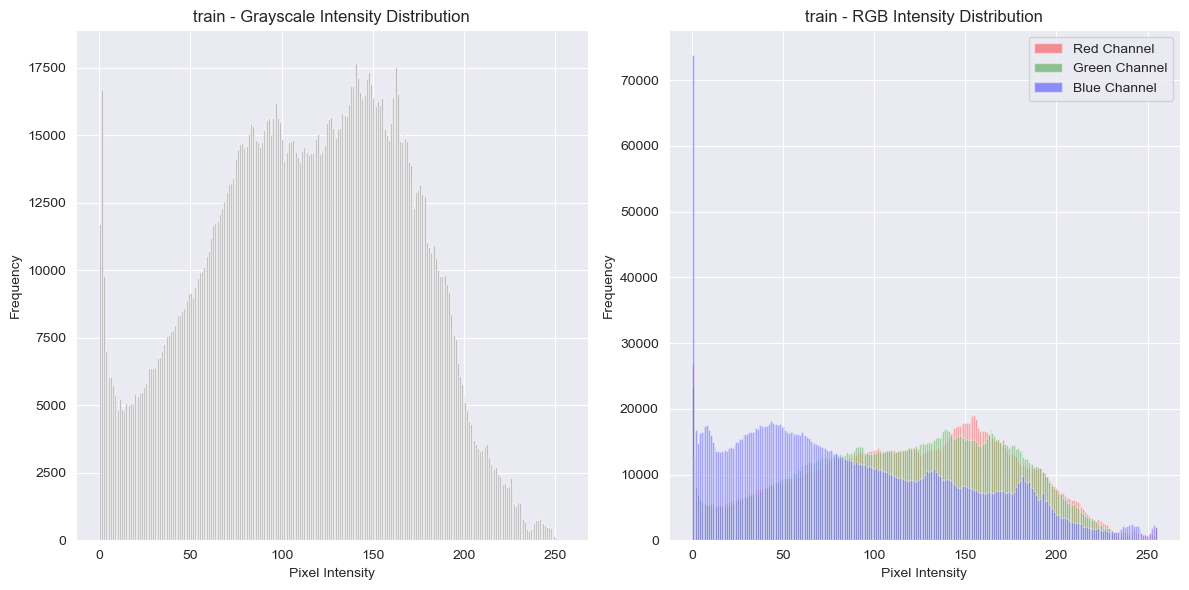

Intensity distribution for test set:


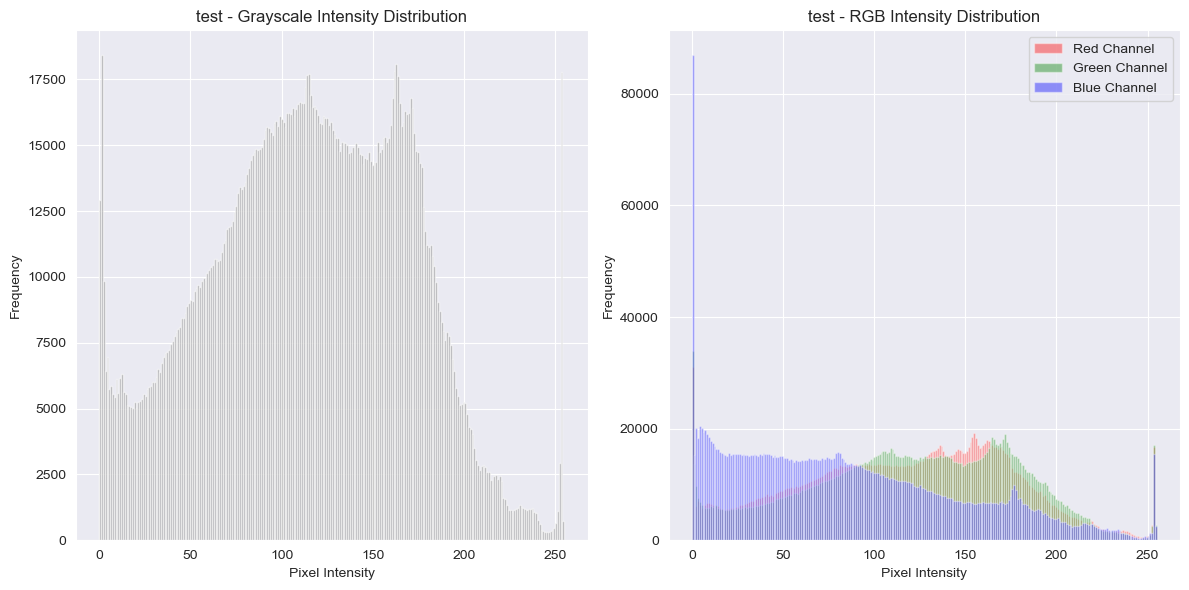

Intensity distribution for validation set:


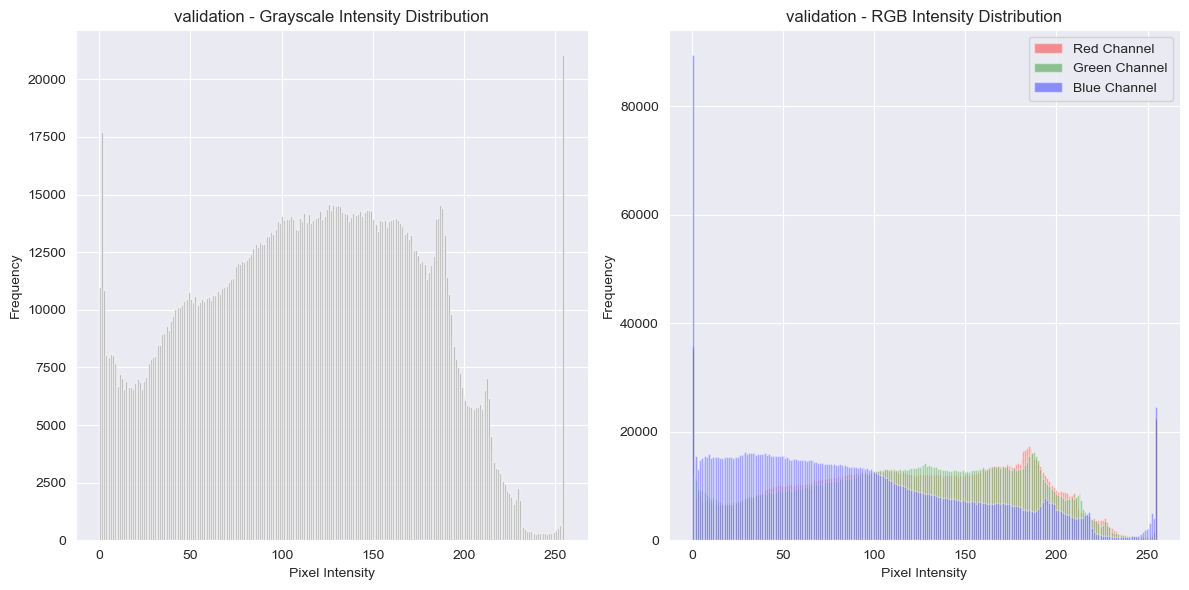

In [99]:


def plot_intensity_distribution(dataset_map, num_samples=50):
    """Visualizes the intensity distribution of images in each set and each channel."""
    for set_type in dataset_map:
        print(f"Intensity distribution for {set_type} set:")
        
        # Initialize lists to accumulate pixel values
        all_pixels_grayscale = []
        all_pixels_red = []
        all_pixels_green = []
        all_pixels_blue = []
        
        # Randomly sample a subset of images to avoid excessive computation
        sampled_images = np.random.sample(dataset_map[set_type], min(num_samples, len(dataset_map[set_type])))
        
        for img, _ in sampled_images:
            # Convert to grayscale and extract pixel values
            img_gray = img.convert("L")
            all_pixels_grayscale.extend(np.array(img_gray).flatten())
            
            # Extract color channels
            img_rgb = img.convert("RGB")
            red, green, blue = img_rgb.split()
            all_pixels_red.extend(np.array(red).flatten())
            all_pixels_green.extend(np.array(green).flatten())
            all_pixels_blue.extend(np.array(blue).flatten())
        
        # Plot histograms
        plt.figure(figsize=(12, 6))
        
        # Grayscale histogram
        plt.subplot(1, 2, 1)
        plt.hist(all_pixels_grayscale, bins=256, color="gray", alpha=0.6)
        plt.title(f"{set_type} - Grayscale Intensity Distribution")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
        
        # RGB Channel Histograms
        plt.subplot(1, 2, 2)
        plt.hist(all_pixels_red, bins=256, color="red", alpha=0.4, label="Red Channel")
        plt.hist(all_pixels_green, bins=256, color="green", alpha=0.4, label="Green Channel")
        plt.hist(all_pixels_blue, bins=256, color="blue", alpha=0.4, label="Blue Channel")
        plt.title(f"{set_type} - RGB Intensity Distribution")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Call the function with your dataset map
plot_intensity_distribution(dataset_map)
